# Saliency Map Demo

This demo is divided into two parts -- model training and . The first is a
slightly simplified example from the `torchgeo` documentation, originally
written by Caleb Robinson, which fine-tunes a land cover classifier using a
ResNet classifier pretrained on a large satellite imagery dataset. The second
shows how we can use the captum package to compute gradient and integrated
gradient-based saliency maps to explain individual predictions, with an eye
especially towards the model's mistakes.

To run this notebook yourself, you can setup a new conda environment with the packages installed:

In [ ]:
# select "stat992_week2" as your notebook kernel
!conda env create -f https://github.com/krisrs1128/stat992_s25/raw/refs/heads/main/demos/stat992_week2.yml

## Model Training

_Written by: Caleb Robinson_

In this tutorial, we demonstrate TorchGeo trainers to train and test a model. We will use the [EuroSAT](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#eurosat) dataset throughout this tutorial. Specifically, a subset containing only 100 images. We will train models to predict land cover classes.

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

In [1]:
%matplotlib inline
%load_ext tensorboard

import torch
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

from torchgeo.datamodules import EuroSAT100DataModule
from torchgeo.models import ResNet18_Weights
from torchgeo.trainers import ClassificationTask
from captum.attr import Saliency, IntegratedGradients
from captum.attr import visualization as viz
torch.manual_seed(20250130)

Matplotlib is building the font cache; this may take a moment.
/opt/miniconda3/envs/stat992_week2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lightning modules

Our trainers use [Lightning](https://lightning.ai/docs/pytorch/stable/) to organize both the training code, and the dataloader setup code. This makes it easy to create and share reproducible experiments and results.

First we'll create a `EuroSAT100DataModule` object which is simply a wrapper around the [EuroSAT100](https://torchgeo.readthedocs.io/en/latest/api/datasets.html#eurosat) dataset. This object 1.) ensures that the data is downloaded, 2.) sets up PyTorch `DataLoader` objects for the train, validation, and test splits, and 3.) ensures that data from the same region **is not** shared between the training and validation sets so that you can properly evaluate the generalization performance of your model.

The following variables can be modified to control training.

In [2]:
batch_size = 25
num_workers = 2
max_epochs = 50

In [3]:
datamodule = EuroSAT100DataModule(root='.', batch_size=batch_size, num_workers=num_workers, download=True)

Next, we create a `ClassificationTask` object that holds the model object, optimizer object, and training logic. We will use a ResNet-18 model that has been pre-trained on Sentinel-2 imagery.

In [4]:
task = ClassificationTask(
    loss='ce',
    model='resnet18',
    weights=ResNet18_Weights.SENTINEL2_ALL_MOCO,
    in_channels=13,
    num_classes=10,
    lr=0.05,
    patience=5,
)

Downloading: "https://hf.co/torchgeo/resnet18_sentinel2_all_moco/resolve/5b8cddc9a14f3844350b7f40b85bcd32aed75918/resnet18_sentinel2_all_moco-59bfdff9.pth" to /Users/malangtian/.cache/torch/hub/checkpoints/resnet18_sentinel2_all_moco-59bfdff9.pth
100%|██████████| 42.8M/42.8M [00:01<00:00, 40.9MB/s]


## Training

Now that we have the Lightning modules set up, we can use a Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) to run the training and evaluation loops. There are many useful pieces of configuration that can be set in the `Trainer` -- below we set up model checkpointing based on the validation loss, early stopping based on the validation loss, and a TensorBoard based logger. We encourage you to see the [Lightning docs](https://lightning.ai/docs/pytorch/stable/) for other options that can be set here, e.g. CSV logging, automatically selecting your optimizer's learning rate, and easy multi-GPU training.

In [5]:
accelerator = 'mps' if torch.backends.mps.is_available() else 'cpu'
logger = TensorBoardLogger(save_dir='.')

For tutorial purposes we deliberately lower the maximum number of training epochs.

In [7]:
trainer = Trainer(
    accelerator=accelerator,
    log_every_n_steps=1,
    logger=logger,
    min_epochs=1,
    max_epochs=max_epochs,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


When we first call `.fit(...)` the dataset will be downloaded and checksummed (if it hasn't already). After this, the training process will kick off, and results will be saved so that TensorBoard can read them.

In [8]:
trainer.fit(model=task, datamodule=datamodule)

100%|██████████| 7.72M/7.72M [00:00<00:00, 16.2MB/s]
100%|██████████| 1.15k/1.15k [00:00<00:00, 2.19MB/s]
100%|██████████| 382/382 [00:00<00:00, 1.34MB/s]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  8.83it/s, v_num=0]           

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s, v_num=0]


We launch TensorBoard to visualize various performance metrics across training and validation epochs. We can see that our model is just starting to converge, and would probably benefit from additional training time and a lower initial learning rate.

In [10]:
%tensorboard --logdir .

Reusing TensorBoard on port 6006 (pid 68318), started 0:00:12 ago. (Use '!kill 68318' to kill it.)

## Interpretability

First, let's extract a batch of examples and compute predictions on them.

In [17]:
data_iter = iter(datamodule.train_dataloader())
batch = next(data_iter)

images = batch["image"]
labels = batch["label"]
predicted = task(batch["image"]).argmax(dim=1)

Let's now visualize all the predictions for this batch along with the ground truth class.

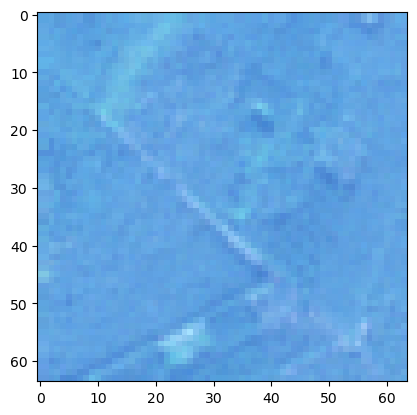

0
Predicted:  Forest
True:  Forest


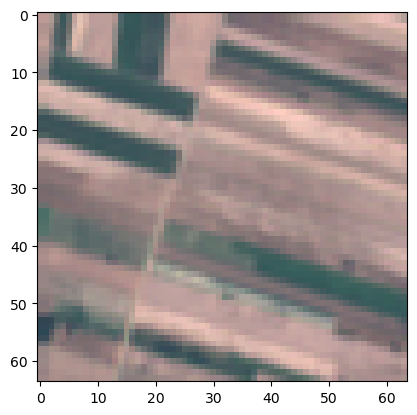

1
Predicted:  Permanent Crop
True:  Annual Crop


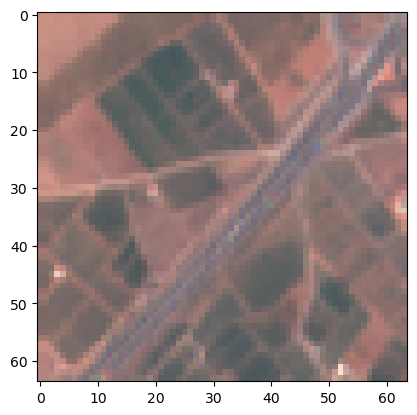

2
Predicted:  Highway
True:  Highway


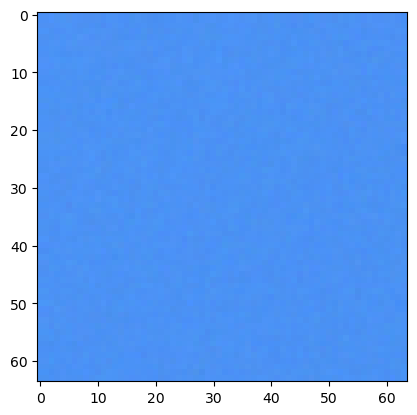

3
Predicted:  River
True:  Sea & Lake


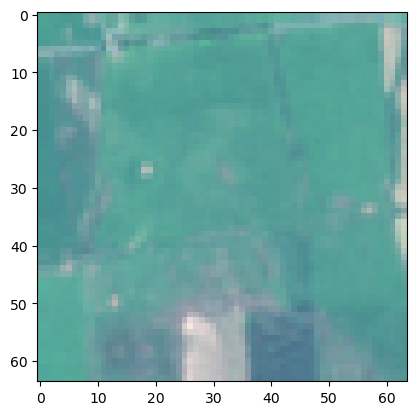

4
Predicted:  Pasture
True:  Pasture


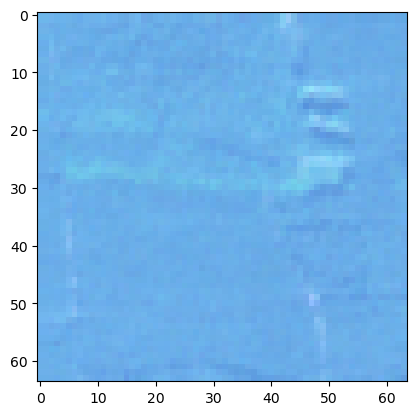

5
Predicted:  Forest
True:  Forest


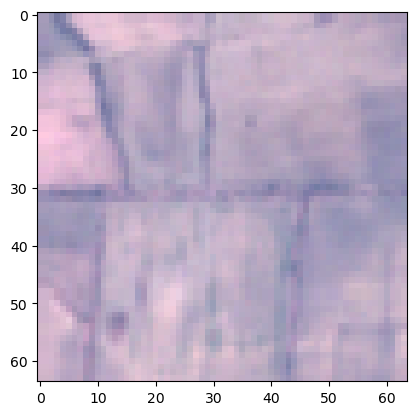

6
Predicted:  Residential Buildings
True:  Pasture


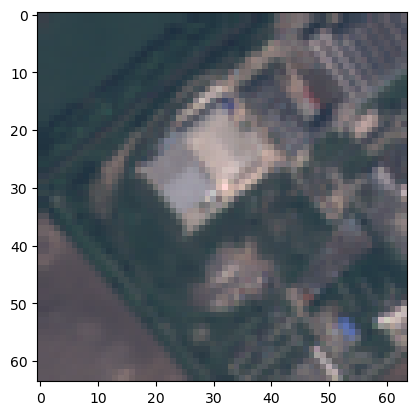

7
Predicted:  Industrial Buildings
True:  Industrial Buildings


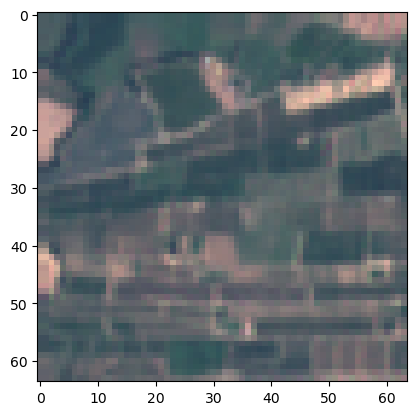

8
Predicted:  Permanent Crop
True:  Permanent Crop


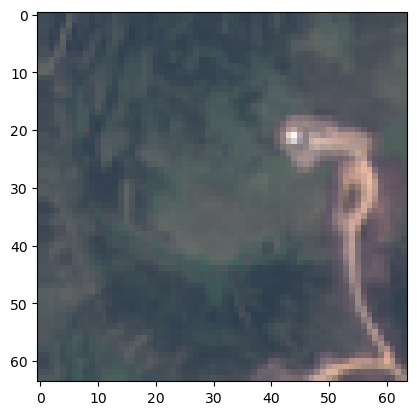

9
Predicted:  Herbaceous Vegetation
True:  Herbaceous Vegetation


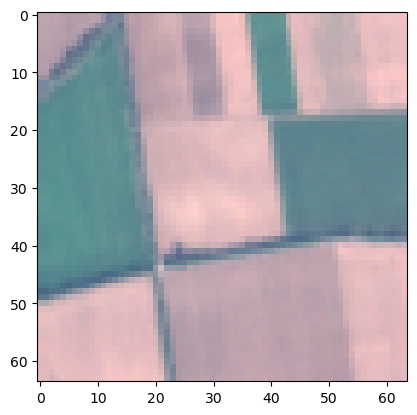

10
Predicted:  Highway
True:  Annual Crop


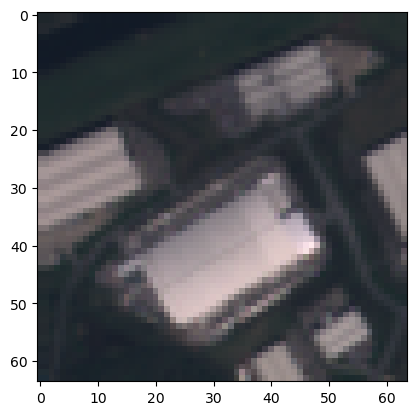

11
Predicted:  Industrial Buildings
True:  Industrial Buildings


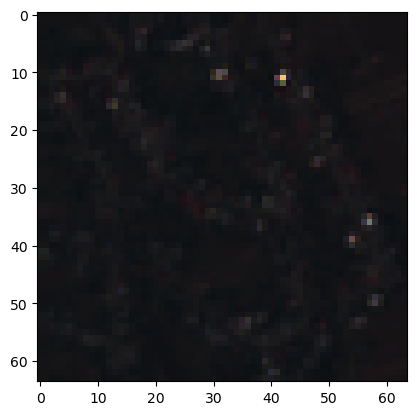

12
Predicted:  Residential Buildings
True:  Residential Buildings


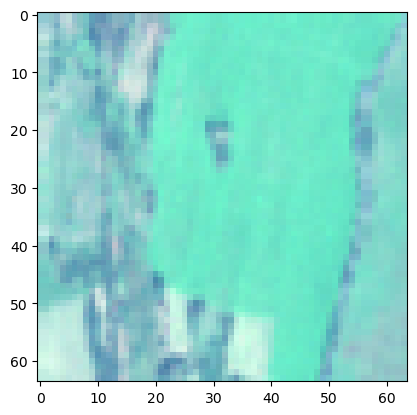

13
Predicted:  Pasture
True:  Pasture


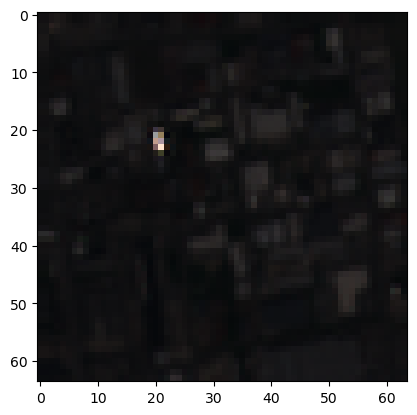

14
Predicted:  Industrial Buildings
True:  Industrial Buildings


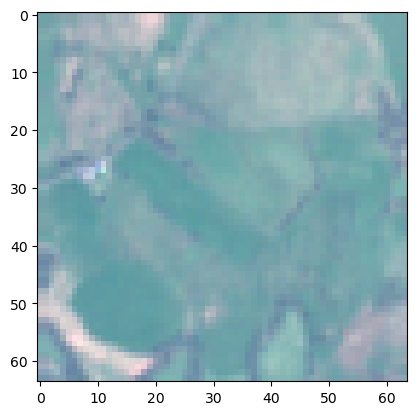

15
Predicted:  Pasture
True:  Pasture


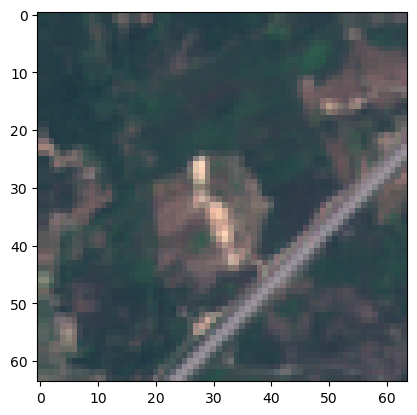

16
Predicted:  Highway
True:  Highway


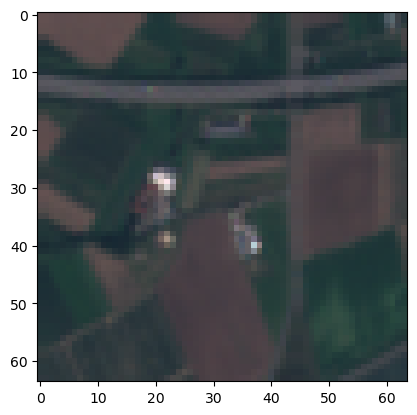

17
Predicted:  Highway
True:  Highway


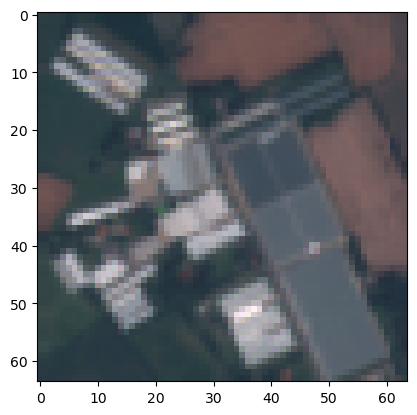

18
Predicted:  Industrial Buildings
True:  Industrial Buildings


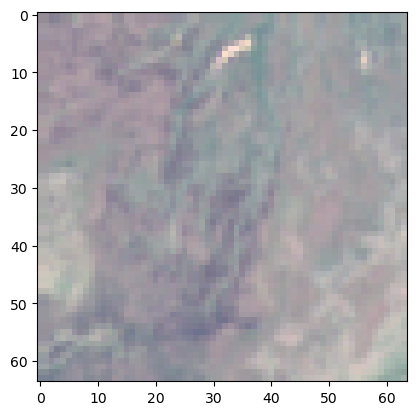

19
Predicted:  Herbaceous Vegetation
True:  Herbaceous Vegetation


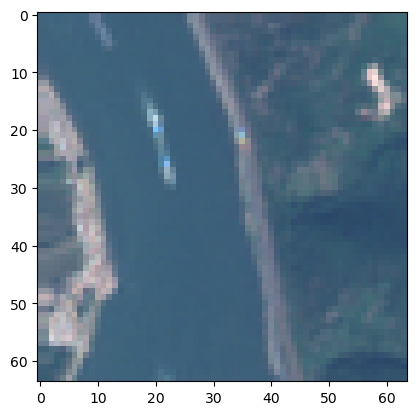

20
Predicted:  River
True:  River


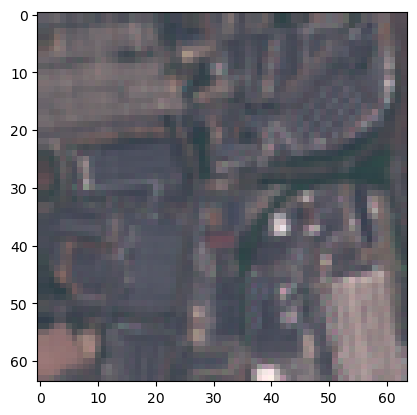

21
Predicted:  Industrial Buildings
True:  Industrial Buildings


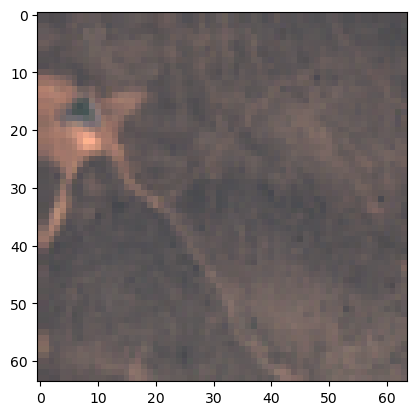

22
Predicted:  Residential Buildings
True:  Herbaceous Vegetation


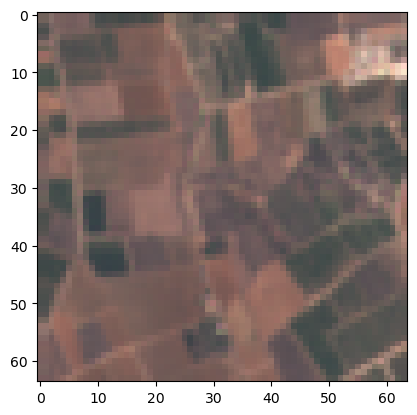

23
Predicted:  Permanent Crop
True:  Permanent Crop


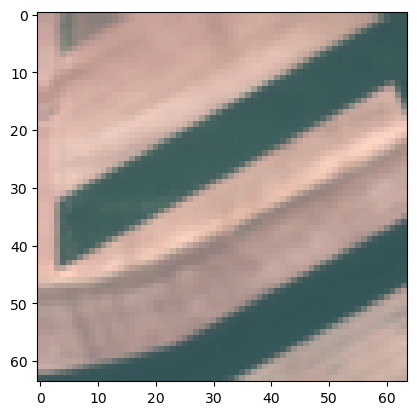

24
Predicted:  Annual Crop
True:  Annual Crop


In [18]:
import matplotlib.pyplot as plt
import numpy as np

label_ = ["Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
          "Industrial Buildings", "Pasture", "Permanent Crop", 
          "Residential Buildings", "River", "Sea & Lake"]

for index in range(batch_size):
    input_image = images[index].unsqueeze(0)
    x = input_image.detach().numpy()[0, [3,2,1]]

    # plot the model's prediction
    plt.imshow(np.transpose(x, (1, 2, 0))/ x.max())
    plt.show()
    output = task(input_image)

    print(index)
    print("Predicted: ", label_[predicted[index]])
    print("True: ", label_[labels[index]])

Some of the mistakes seem to occur on ambiguous regions, where parts of the image seem to correspond to one class while other parts correspond to a different one. We can try to gauge this hypothesis by using different types of saliency maps. The results are not definitive. For both saliency maps and integrated gradients, the model seems to attend to parts of the image from both the correct class and the distracting background. Our hypothesis might be part of the story, but it doesn't seem to be the complete one.

/opt/miniconda3/envs/stat992_week2/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


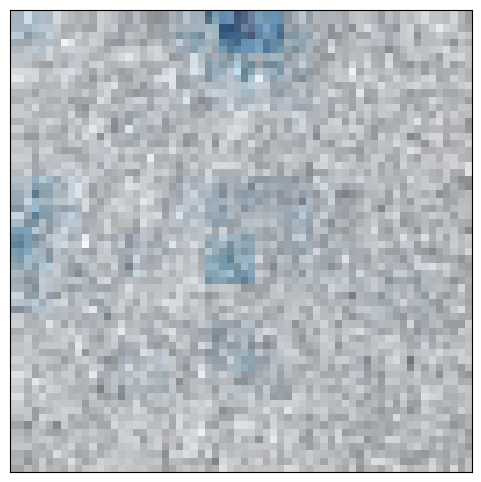

In [19]:
index = 3
input_image = batch["image"][index].unsqueeze(0)
x = input_image.detach().numpy()[0, [3,2,1]]
x = np.transpose(x, (1, 2, 0))

# initialize a Saliency object
saliency = Saliency(task.model)
z = saliency.attribute(input_image, target=predicted[index])

# postprocess and visualize
z = z.detach().numpy()[0]
z = np.transpose(z, (1, 2, 0))
_ = viz.visualize_image_attr(z, x, method = "blended_heat_map")

In [ ]:
ig =  # ?

# postprocess the integrated gradients
#z = z.detach().numpy()[0]
#z = np.transpose(z, (1, 2, 0))